# Load: part-of-speech-olive

In [1]:
import pickle
import pandas as pd

from tqdm.auto import tqdm

In [2]:
model_name = "part-of-speech-olive-cormorant"

In [3]:
with open("/home/eeisenst/workspace/compassionai/data-registry/processed_datasets/part-of-speech-olive/train.pkl", "rb") as f:
    train_data = pickle.load(f)
with open("/home/eeisenst/workspace/compassionai/data-registry/processed_datasets/part-of-speech-olive/test.pkl", "rb") as f:
    test_data = pickle.load(f)

In [4]:
len(train_data), len(test_data)

(28234, 3075)

In [5]:
def _to_list_of_lists(data):
    res = []
    for example in tqdm(data):
        cur_res = ([], [])
        cur_word, cur_tag = [], set()
        for token, tag in zip(*example):
            if tag == '[MASK]':
                continue
            cur_word.append(token)
            cur_tag = cur_tag.union(set(tag.split('+')))
            if '[WORD_END]' in cur_tag:
                cur_tag = sorted(filter(lambda x: not x == '[WORD_END]', list(cur_tag)))
                cur_res[0].append(cur_word)
                cur_res[1].append('+'.join(cur_tag))
                cur_word, cur_tag = [], set()
        res.append(cur_res)
    return res

In [6]:
train_data = _to_list_of_lists(train_data)
test_data = _to_list_of_lists(test_data)

  0%|          | 0/28234 [00:00<?, ?it/s]

  0%|          | 0/3075 [00:00<?, ?it/s]

In [7]:
train_words = set([' '.join(map(str, word)) for words, _ in train_data for word in words])
len(list(train_words))

22876

In [8]:
test_words = set([' '.join(map(str, word)) for words, _ in test_data for word in words])
len(list(test_words))

6008

In [9]:
len(list(test_words - train_words))

1383

In [10]:
test_word_lens = pd.Series([len(word) for word in test_words])

<AxesSubplot:>

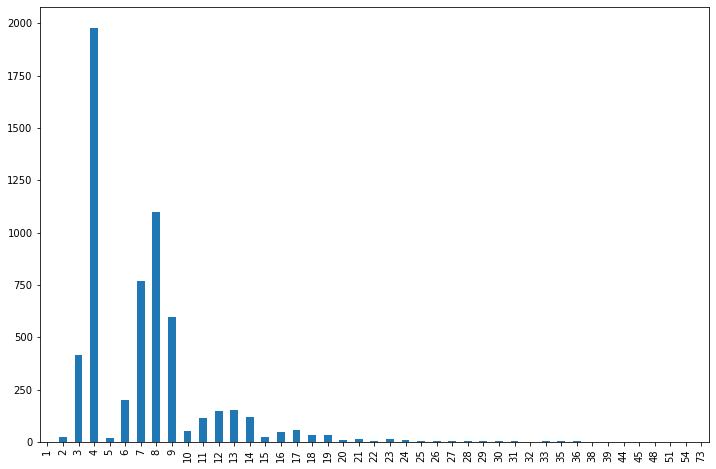

In [11]:
test_word_lens.value_counts().sort_index().plot(kind='bar', figsize=(12,8))

# Load: part-of-speech-intersyllabic-olive

In [1]:
import pickle
import pandas as pd

In [14]:
model_name = "part-of-speech-intersyllabic-olive-cormorant"

In [3]:
with open("/home/eeisenst/workspace/compassionai/data-registry/processed_datasets/part-of-speech-intersyllabic-olive/train.pkl", "rb") as f:
    train_data = pickle.load(f)
with open("/home/eeisenst/workspace/compassionai/data-registry/processed_datasets/part-of-speech-intersyllabic-olive/test.pkl", "rb") as f:
    test_data = pickle.load(f)

In [4]:
train_data[0]

([[3397, 213, 1276],
  [9901, 9927, 2981, 1296, 458],
  [17],
  [1007],
  [2171],
  [9888, 9877],
  [9955]],
 ['NOUN', 'PROPN', 'ADP', 'NOUN', 'VERB', 'PART', 'PUNCT'])

In [5]:
len(train_data), len(test_data)

(28167, 3129)

In [6]:
train_words = set([' '.join(map(str, word)) for words, _ in train_data for word in words])
len(list(train_words))

20628

In [7]:
test_words = set([' '.join(map(str, word)) for words, _ in test_data for word in words])
len(list(test_words))

5703

In [8]:
len(list(test_words - train_words))

1261

In [9]:
test_word_lens = pd.Series([len(word) for word in test_words])

<AxesSubplot:>

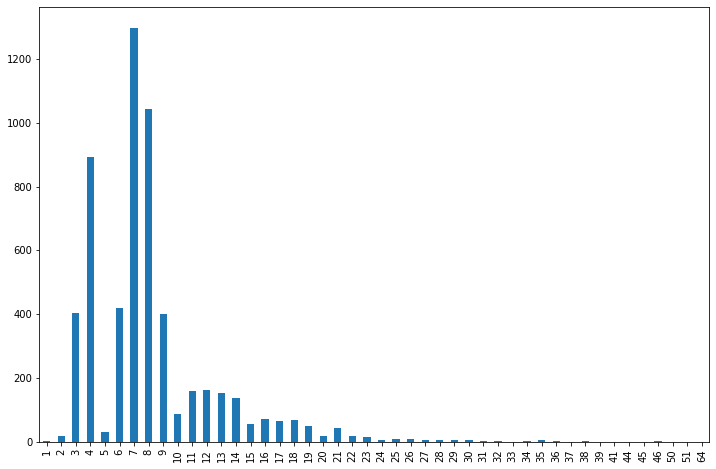

In [10]:
test_word_lens.value_counts().sort_index().plot(kind='bar', figsize=(12,8))

# Classification metrics on new words

In [11]:
from tqdm.auto import tqdm

In [12]:
from cai_manas.part_of_speech.pos_tagger import PartOfSpeechTagger

In [15]:
tagger = PartOfSpeechTagger(model_name)

In [16]:
res_tokens, res_tags, res_labels = [], [], []
for datum in tqdm(test_data):
    # _, cur_tags = tagger.predict_tags(tagger.tokenizer.decode([token for word in datum[0] for token in word]))
    if len(datum[0]) == 0:
        continue
    try:
        cur_tags = tagger.predict_tokens([token for word in datum[0] for token in word])
    except:
        print(datum)
        raise Exception()
    cur_tags = [tagger.id_to_label_map[pred] for pred in cur_tags[1:-1]]
    res_tokens.append(datum[0])
    res_tags.append(cur_tags)
    seq_labels = []
    for word, word_label in zip(datum[0], datum[1]):
        seq_labels.append(word_label)
        for _ in range(len(word) - 1):
            seq_labels.append('[MASK]')
    res_labels.append(seq_labels)

  0%|          | 0/3129 [00:00<?, ?it/s]

In [25]:
strange_tags, strange_labels = [], []
# for test_word in tqdm(list(test_words.intersection(train_words))):
for test_word in tqdm(list(test_words - train_words)):
    test_tokens = list(map(int, test_word.split(' ')))
    for example, tags, labels in zip(res_tokens, res_tags, res_labels):
        example_str = [' '.join(map(str, word)) for word in example]
        if test_word in example_str:
            word_idx = example.index(test_tokens)
            tag_idx = sum([len(word) for word in example[:word_idx]])
            strange_tags.extend(tags[tag_idx:tag_idx+len(example[word_idx])])
            strange_labels.extend(labels[tag_idx:tag_idx+len(example[word_idx])])

  0%|          | 0/1261 [00:00<?, ?it/s]

In [27]:
label2id = {
    label.upper(): id_
    for id_, label in tagger.id_to_label_map.items()
}
strange_tags = [label2id[t.upper()] for t in strange_tags]
strange_labels = [label2id.get(l.upper(), label2id['UNK']) for l in strange_labels]

In [28]:
from sklearn.metrics import precision_recall_fscore_support

In [29]:
precision, recall, f1, support = precision_recall_fscore_support(strange_labels, strange_tags)

/home/eeisenst/miniconda3/envs/cai-garland/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/eeisenst/miniconda3/envs/cai-garland/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [30]:
res_df = {
    "tag": [],
    "Precision": [],
    "Recall": [],
    "F1": [],
    "Support": []
}
for tag, tag_precision, tag_recall, tag_f1, tag_support in zip(
    [tagger.id_to_label_map[i] for i in range(len(f1))], precision, recall, f1, support
):
    res_df["tag"].append(tag)
    res_df["Precision"].append(tag_precision)
    res_df["Recall"].append(tag_recall)
    res_df["F1"].append(tag_f1)
    res_df["Support"].append(tag_support)
res_df = pd.DataFrame(res_df).set_index('tag').sort_values("Support", ascending=False)
res_df

,Precision,Recall,F1,Support
tag,,,,
PUNCT,0.970143,0.926878,0.948017,2489
DET,0.739943,0.878840,0.803432,586
NUM+ADP,0.695652,0.636816,0.664935,201
DET+ADP,0.777778,0.862319,0.817869,138
DET+PART,0.876543,0.855422,0.865854,83
PART+PART,0.680412,0.891892,0.771930,74
PROPN,0.565217,0.433333,0.490566,60
ADJ,0.604167,0.491525,0.542056,59
NUM+PART,0.724138,0.477273,0.575342,44
